In [56]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from audicor_reader.reader import read_IEC, get_ekg
from utils.data_utils import ekg_denoise, load_raw_dataset_and_bbox_labels, entropy_calc, smooth_signal, normalize, onset_offset_generator
from model.RetinaNet import RetinaNet
from evaluation.test_retinanet import test_retinanet, removeworst
import os
import json
from rdp import rdp
%matplotlib inline

In [57]:
signals, bboxes, label1s, peaks = load_raw_dataset_and_bbox_labels(os.environ['HOME'] + "/PQRST/unet/data/ecg_data_200.json")

In [58]:
def plot(sig, name=""):
    plt.figure(figsize=(40, 5))
    plt.title(name)
    plt.plot(range(sig.shape[1]), sig[0])
    plt.show()

In [59]:
leads_names = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
def check_ludb_label(raw_dataset):
    with open(raw_dataset, 'r') as f:
        data = json.load(f)
    for case_id in data.keys():
        leads = data[case_id]['Leads']
        for i in range(len(leads_names)):
            lead_name = leads_names[i]

            delineation_tables = leads[leads_names[0]]['DelineationDoc']
            
            p_delin = delineation_tables['p']
            qrs_delin = delineation_tables['qrs']
            t_delin = delineation_tables['t']

            # skip the data that missed at least one segment.
            if len(p_delin) == 0 or len(qrs_delin) == 0 or len(t_delin) == 0:
                plot(np.array(leads['ii']['Signal']).reshape((1, -1)))
                print("p" if len(p_delin) == 0 else "", "qrs" if len(qrs_delin)==0 else "", "t" if len(t_delin)==0 else "")
                break
                
            #x.append(leads[lead_name]['Signal'][start_point:end_point])


In [60]:
def check_entropy(data):
    res = []
    for i in range(len(data)):
        res.append(entropy_calc(data[i]))
    return res

In [64]:
ekg_sig = []
for i in range(1, 126):
    ekg_filename = '/mnt/nas/homes/Wr1t3R/PQRST/unet/data/IEC/IEC_from_audicor/CSE'+ str(i).rjust(3, '0') + '.raw'
    try:
        sig = read_IEC(ekg_filename)
        ekg_sig.append(sig[0].astype(float))
    except IOError:
        continue
        #print("file {} does not exist".format("CSE"+str(i).rjust(3, '0')))
print(check_entropy(ekg_sig))


[4.20300464180858, 4.716551065364213, 4.313012088251661, 3.929862071706621, 4.186614784665693, 4.3041364178603105, 3.5187577669133545, 3.9733545753345414, 4.10544517654572, 3.593233749409017, 3.974099860182296, 3.890719444114784, 3.4366394898482144, 4.590248140439934, 3.531388794561442, 3.9654347751545633, 4.239482419523833, 4.2210007931912035, 3.4509123736442566, 4.057286935871932, 4.749076882120406, 4.267686838643149, 4.0354409187348255, 3.830961780457256, 4.244953783886997, 3.564079234847503, 3.9063142224252587, 4.193712690637027, 4.211233601680192, 4.028491256201003, 3.387762499105105, 4.059312178269128, 4.194226336004976, 3.852146242691924, 3.4280193502920495, 4.138218050848175, 4.218276442908398, 3.8030229872456114, 4.396316453254471, 4.071942681906488, 3.8902590502801466, 3.6432532721737463, 3.752956685977659, 4.03374304223506, 4.341815495770749, 4.336447032972795, 3.8650543376236457, 4.079148006763723, 3.9900870531721537, 4.11860178188424, 4.071106606099224, 3.7474260444870806,

In [66]:
name = ["ANE20000", "ANE20001", "ANE20002", 
    "CAL05000", "CAL10000", "CAL15000", 
    "CAL20000", "CAL20002", "CAL20100", 
    "CAL20110", "CAL20160", "CAL20200", 
    "CAL20210", "CAL20260", "CAL20500",
    "CAL30000", "CAL50000"]
CAL_sig = []
for i in range(len(name)):
    for j in range(1, 6):
        ekg_filename = f'/mnt/nas/homes/Wr1t3R/PQRST/unet/data/IEC/IEC_from_audicor/{name[i]}_{str(j)}.raw'
        try:
            sig = read_IEC(ekg_filename)
            CAL_sig.append(sig[0].astype(float))
        except IOError:
            continue
            #print(f"file {name[i]}_{str(j)} does not exist")
print(check_entropy(CAL_sig))

[3.5992330194351925, 3.6115391032014363, 3.599342345264792, 3.5979097216596805, 3.599367348695078, 3.402383168257706, 3.46379846030135, 3.355273020770906, 3.498923702502135, 3.463353580387841, 4.3923022104861245, 4.382446094332703, 4.383634544957655, 4.3897684056233786, 4.394251599442791, 2.884671352625196, 2.8997926271976375, 2.8766918626222293, 2.909290149258154, 2.920840046638069, 3.122811193410078, 3.136385542280162, 3.125678370903662, 3.1262004925218583, 3.142801865376069, 3.3173026979895917, 3.3278320633330143, 3.3588448784834073, 3.3064083112382603, 3.3087280340393823, 3.4653331576069113, 3.4402482812071726, 3.4580782468061173, 3.457178342523041, 3.451777143326013, 4.320408292123325, 4.320097631749404, 4.339328388682305, 4.34777032074957, 4.322921790136472, 3.3903314626110665, 3.3759645654974415, 3.3802736235800963, 3.3798893365459453, 3.380318453870314, 3.604289451745646, 3.6111823219843, 3.598444141350833, 3.6017499115768463, 3.5928031574845054, 3.7275364758208593, 3.709978395

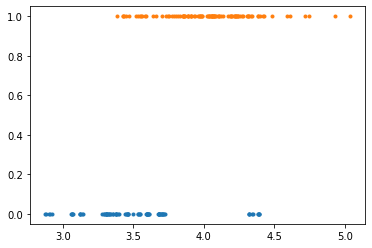

In [8]:
CAL = check_entropy(CAL_sig)
CSE = check_entropy(ekg_sig)
plt.plot(CAL, np.zeros_like(CAL), '.')
plt.plot(CSE, np.zeros_like(CSE) + 1, '.')

In [9]:
def signal_rdp(signal, epsilon):
    process_data = []
    for i in range(len(signal)):
        process_data.append([i, signal[i]])
    processed = rdp(process_data, epsilon=epsilon)
    ret = []
    for i in range(len(processed)):
        ret.append(int(processed[i][0]))
    return ret

In [70]:
CAL_sig = np.array(CAL_sig)
turn_point = []
for i in range(0, CAL_sig.shape[0]):
    print(i, end=" ")
    #plt.figure(figsize=(40, 5))
    #plt.plot(CAL_sig[i])
    ret = signal_rdp(CAL_sig[i], 7.5)
    turn_point.append(ret)
    #plt.plot(ret, CAL_sig[i, ret], 'x')
    #plt.show()
print(len(turn_point))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85


In [89]:
print(len(turn_point[0]))

114


In [71]:
CAL_sig = CAL_sig[:, np.newaxis, :].astype(float)
CAL_sig = torch.Tensor(CAL_sig).cuda()[:, :, :4992]
CAL_sig = normalize(CAL_sig)
net = RetinaNet(3).cuda()
net.load_state_dict(torch.load("weights/retinanet_best_pass_all(CAL)_22.pkl"))
final_preds = []
for i in range(CAL_sig.size(0) // 128 + 1):
    _, _, pred_signals = test_retinanet(net, CAL_sig[i*128:(i+1)*128, :, :], 4992, visual=False)
    final_preds.append(pred_signals)
final_preds = torch.cat(final_preds, dim=0)
print(final_preds.size())
CAL_sig = CAL_sig.cpu().numpy()

torch.Size([85, 4, 4992])


In [72]:
onset_offset = onset_offset_generator(final_preds)
print(onset_offset[onset_offset==1])
qrs_interval = []
for j in range(onset_offset.shape[0]):
    qrs_interval.append([])
    i = 0
    while i < 4992:
        if onset_offset[j, 2, i] == -1:
            qrs_interval[j].append([i])
            i += 1
            while onset_offset[j, 2, i] == 0:
                i += 1
            qrs_interval[j][-1].append(i)
        i += 1
print(qrs_interval[10])

[1. 1. 1. ... 1. 1. 1.]
[[173, 218], [424, 470], [674, 720], [921, 970], [1172, 1219], [1423, 1468], [1670, 1718], [1922, 1967], [2171, 2220], [2421, 2469], [2673, 2719], [2923, 2969], [3175, 3220], [3423, 3471], [3671, 3720], [3924, 3969], [4173, 4219], [4421, 4469], [4675, 4721], [4922, 4967]]


In [75]:
def enlarge_qrs_list(origin):
    ret = origin.copy()
    for i in range(len(ret)):
        for j in range(len(ret[i])):
            ret[i][j][0] -= 7
            ret[i][j][1] += 7
    return ret
enlarge_qrs = enlarge_qrs_list(qrs_interval)

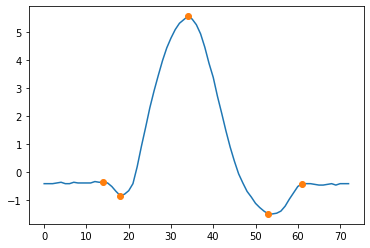

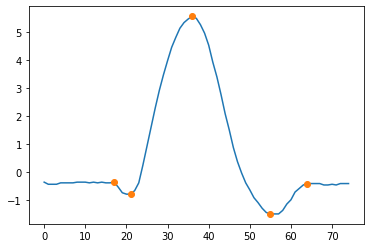

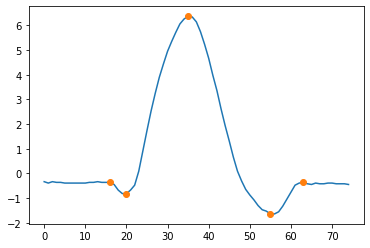

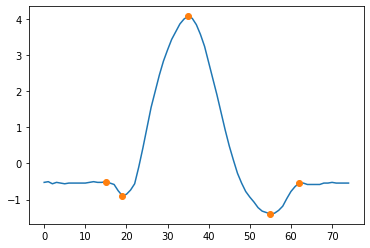

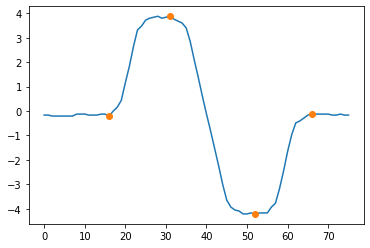

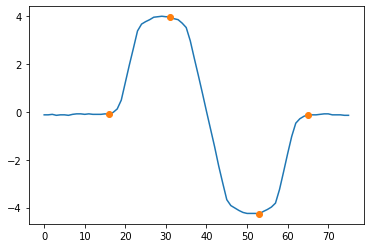

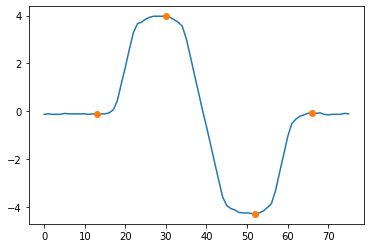

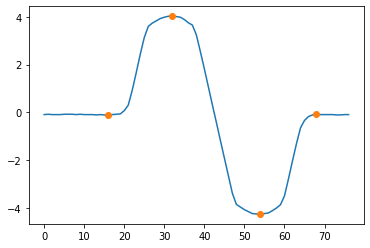

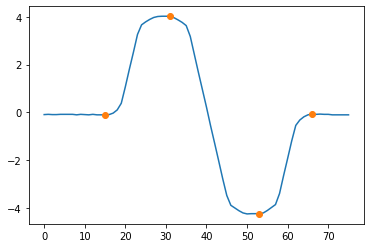

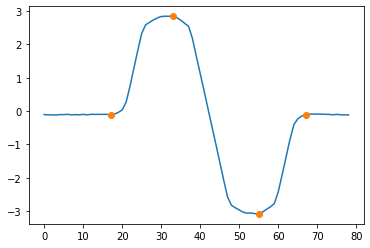

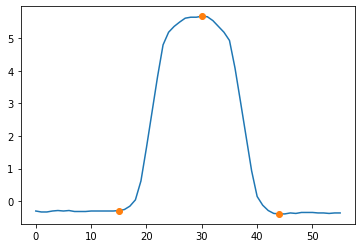

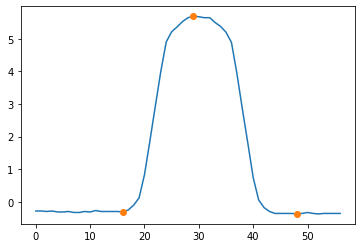

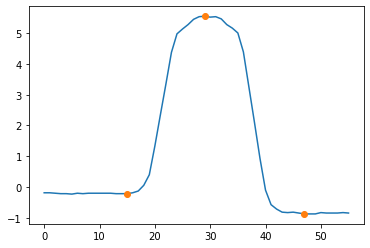

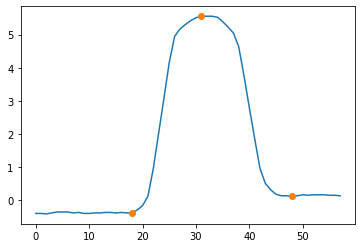

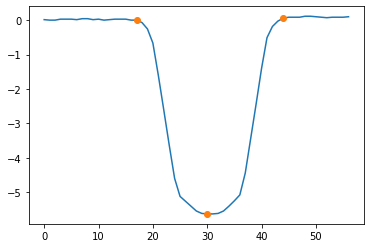

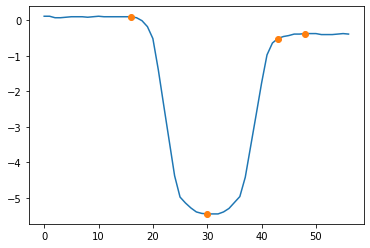

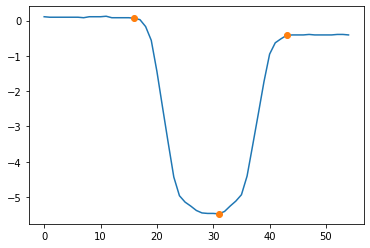

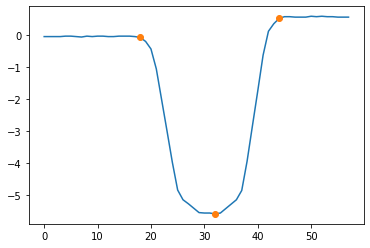

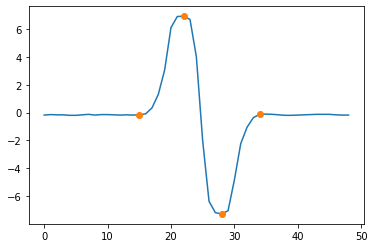

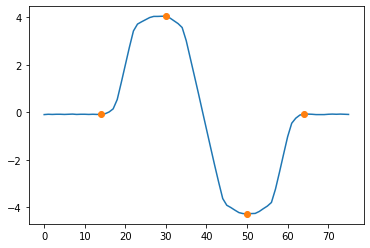

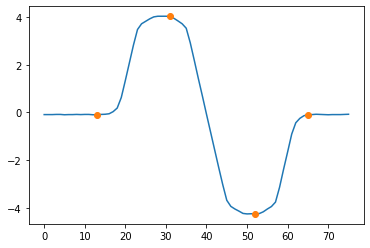

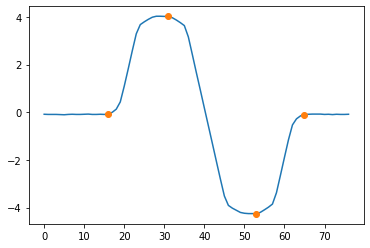

In [88]:
#turning = []
for index in range(0, 85, 4):
    #turning.append([])
    for j in range(len(enlarge_qrs[index])):
        filtered_peaks = list(filter(lambda i: i >= enlarge_qrs[index][j][0] and i <= enlarge_qrs[index][j][1], turn_point[index]))
        #turning[index].append(filtered_peaks)
        idx = find_index_closest_to_value(CAL_sig[index, 0, filtered_peaks[1]: filtered_peaks[2]], CAL_sig[index, 0, filtered_peaks[0]])
        idx = idx + filtered_peaks[1] - enlarge_qrs[index][j][0]
        filtered_peaks = [i - enlarge_qrs[index][j][0] for i in filtered_peaks]
        plt.plot(CAL_sig[index, 0, enlarge_qrs[index][j][0]: enlarge_qrs[index][j][1]])
        #plt.plot(idx, CAL_sig[index, 0, enlarge_qrs[index][j][0]: enlarge_qrs[index][j][1]][idx], 'o')
        plt.plot(filtered_peaks, CAL_sig[index, 0, enlarge_qrs[index][j][0]: enlarge_qrs[index][j][1]][filtered_peaks], 'o')
        #plt.plot(filtered_peaks[0]-enlarge_qrs[index][j][0], CAL_sig[index, 0, enlarge_qrs[index][j][0]: enlarge_qrs[index][j][1]][filtered_peaks[0]-enlarge_qrs[index][j][0]], 'o')
        #idx = find_index_closest_to_value(CAL_sig[index, 0, filtered_peaks[2]: filtered_peaks[3]], CAL_sig[index, 0, filtered_peaks[4]])
        #idx = idx + filtered_peaks[2] - enlarge_qrs[index][j][0]
        #plt.plot(idx, CAL_sig[index, 0, enlarge_qrs[index][j][0]: enlarge_qrs[index][j][1]][idx], 'o')
        #plt.plot(filtered_peaks[4]-enlarge_qrs[index][j][0], CAL_sig[index, 0, enlarge_qrs[index][j][0]: enlarge_qrs[index][j][1]][filtered_peaks[4]-enlarge_qrs[index][j][0]], 'o')
        #plt.plot(filtered_peaks[3]-enlarge_qrs[index][j][0], CAL_sig[index, 0, enlarge_qrs[index][j][0]: enlarge_qrs[index][j][1]][filtered_peaks[3]-enlarge_qrs[index][j][0]], 'o')
        #plt.plot(filtered_peaks[2]-enlarge_qrs[index][j][0], CAL_sig[index, 0, enlarge_qrs[index][j][0]: enlarge_qrs[index][j][1]][filtered_peaks[2]-enlarge_qrs[index][j][0]], 'o')
        
        plt.show()
        break


In [77]:
def find_index_closest_to_value(li, value):
    li = np.array(li)
    return np.argmin(abs(li-value))

In [78]:
pred = []
for i in range(len(turning)):
    pred.append({"q_duration": [], "r_duration": [], "s_duration": []})
    # ignore the number of points find that are not equal to mode
    mode = np.argmax(np.bincount([len(i) for i in turning[i]]))
    for j in range(len(turning[i])):
        if len(turning[i][j]) != mode:
            continue
        if mode >= 5:
            # q,r,s
            # find q duration
            q_end = find_index_closest_to_value(CAL_sig[i, 0, turning[i][j][1]: turning[i][j][2]], CAL_sig[i, 0, turning[i][j][0]])
            q_end = q_end + turning[i][j][1]
            q_duration = q_end - turning[i][j][0]
            pred[i]["q_duration"].append(q_duration)
            # find s duration
            s_start = find_index_closest_to_value(CAL_sig[i, 0, turning[i][j][2]: turning[i][j][3]], CAL_sig[i, 0, turning[i][j][4]])
            s_start = s_start + turning[i][j][2]
            s_duration = turning[i][j][4] - s_start
            pred[i]["s_duration"].append(s_duration)
            # find r duration
            r_start = q_end
            r_end = s_start
            r_duration = r_end - r_start
            pred[i]["r_duration"].append(r_duration)
        elif mode == 4:
            # q,r or r,s
            if CAL_sig[i, 0, turning[i][j][1]] > CAL_sig[i, 0, turning[i][j][2]]:
                pred[i]["q_duration"].append(0)
                # r, s            
                # find s duration
                s_start = find_index_closest_to_value(CAL_sig[i, 0, turning[i][j][1]: turning[i][j][2]], CAL_sig[i, 0, turning[i][j][3]])
                s_start = s_start + turning[i][j][1]
                s_duration = turning[i][j][3] - s_start
                pred[i]["s_duration"].append(s_duration)
                # find r duration
                r_end = s_start
                r_duration = r_end - turning[i][j][0]
                pred[i]["r_duration"].append(r_duration)
            else:
                if i == 84:
                    print(turning[i][j][1], turning[i][j][2])
                # q, r
                pred[i]["s_duration"].append(0)
                # find q duration
                q_end = find_index_closest_to_value(CAL_sig[i, 0, turning[i][j][1]: turning[i][j][2]], CAL_sig[i, 0, turning[i][j][0]])
                q_end = q_end + turning[i][j][1]
                q_duration = q_end - turning[i][j][0]
                pred[i]["q_duration"].append(q_duration)                
                # find r duration
                r_start = q_end
                r_duration = turning[i][j][3] - r_start
                pred[i]["r_duration"].append(r_duration)
        elif mode <= 3:
            # only q or r
            if CAL_sig[i, 0, turning[i][j][1]] > CAL_sig[i, 0, turning[i][j][0]]:
                # r
                pred[i]["q_duration"].append(0)
                pred[i]["s_duration"].append(0)
                r_duration = turning[i][j][2] - turning[i][j][0]
                pred[i]["r_duration"].append(r_duration)
            else:
                # q
                pred[i]["r_duration"].append(0)
                pred[i]["s_duration"].append(0)
                q_duration = turning[i][j][2] - turning[i][j][0]
                pred[i]["q_duration"].append(q_duration)
print(pred[40])

{'q_duration': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'r_duration': [29, 32, 29, 29, 30, 29, 31, 29, 28, 27], 's_duration': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [54]:
standard_qrs = []
# ANE
standard_qrs.append({"q_duration": 12, "r_duration": 52, "s_duration": 30})
standard_qrs.append({"q_duration": 12, "r_duration": 52, "s_duration": 30})
standard_qrs.append({"q_duration": 12, "r_duration": 52, "s_duration": 30})
#CAL
standard_qrs.append({"q_duration": 0, "r_duration": 50, "s_duration": 50})
standard_qrs.append({"q_duration": 0, "r_duration": 50, "s_duration": 50})
standard_qrs.append({"q_duration": 0, "r_duration": 50, "s_duration": 50})
standard_qrs.append({"q_duration": 0, "r_duration": 50, "s_duration": 50})
standard_qrs.append({"q_duration": 0, "r_duration": 50, "s_duration": 50})
standard_qrs.append({"q_duration": 0, "r_duration": 56, "s_duration": 0})
standard_qrs.append({"q_duration": 0, "r_duration": 56, "s_duration": 0})
standard_qrs.append({"q_duration": 0, "r_duration": 56, "s_duration": 0})
standard_qrs.append({"q_duration": 56, "r_duration": 0, "s_duration": 0})
standard_qrs.append({"q_duration": 56, "r_duration": 0, "s_duration": 0})
standard_qrs.append({"q_duration": 56, "r_duration": 0, "s_duration": 0})
standard_qrs.append({"q_duration": 0, "r_duration": 18, "s_duration": 18})
standard_qrs.append({"q_duration": 0, "r_duration": 50, "s_duration": 50})
standard_qrs.append({"q_duration": 0, "r_duration": 50, "s_duration": 50})


In [55]:
mean_diff = np.zeros((3, 17))
for i in range(17):
    q_temp_mean = []
    r_temp_mean = []
    s_temp_mean = []
    for j in range(5):
        q_temp_mean.append(np.mean(pred[i*5+j]["q_duration"]))
        r_temp_mean.append(np.mean(pred[i*5+j]["r_duration"]))
        s_temp_mean.append(np.mean(pred[i*5+j]["s_duration"]))
    mean_diff[0][i] = np.mean(q_temp_mean)*2 - standard_qrs[i]["q_duration"]
    mean_diff[1][i] = np.mean(r_temp_mean)*2 - standard_qrs[i]["r_duration"]
    mean_diff[2][i] = np.mean(s_temp_mean)*2 - standard_qrs[i]["s_duration"]
print(pd.DataFrame(mean_diff.T, columns=["q","r","s"]))
mean_diff = removeworst(mean_diff, 4)
mean_diff_mean = np.mean(mean_diff, axis=1)
mean_diff_std = np.std(mean_diff, axis=1, ddof=1)
print(mean_diff_mean)
print(mean_diff_std)

           q         r         s
0   1.160000 -0.080000 -1.560000
1   1.095238 -0.066667 -0.704762
2   0.586316  0.305380 -1.612632
3   0.000000  1.616667  3.236667
4   0.000000  1.026667  2.662222
5   0.000000 -0.160000  0.897778
6   0.000000  0.822222  0.671111
7   0.000000 -0.696842 -0.138947
8   0.000000  3.826667  0.000000
9   0.000000  2.432222  0.000000
10  0.000000  1.622222  0.000000
11 -0.600000  0.000000  0.000000
12 -1.226667  0.000000  0.000000
13  0.080000  0.000000  0.000000
14  0.000000  1.915556  1.142222
15  0.000000 -0.071111  0.528889
16  0.000000 -0.057778  0.715556
[0.05125506 0.20296446 0.23937279]
[0.16227912 0.60771847 0.51022171]


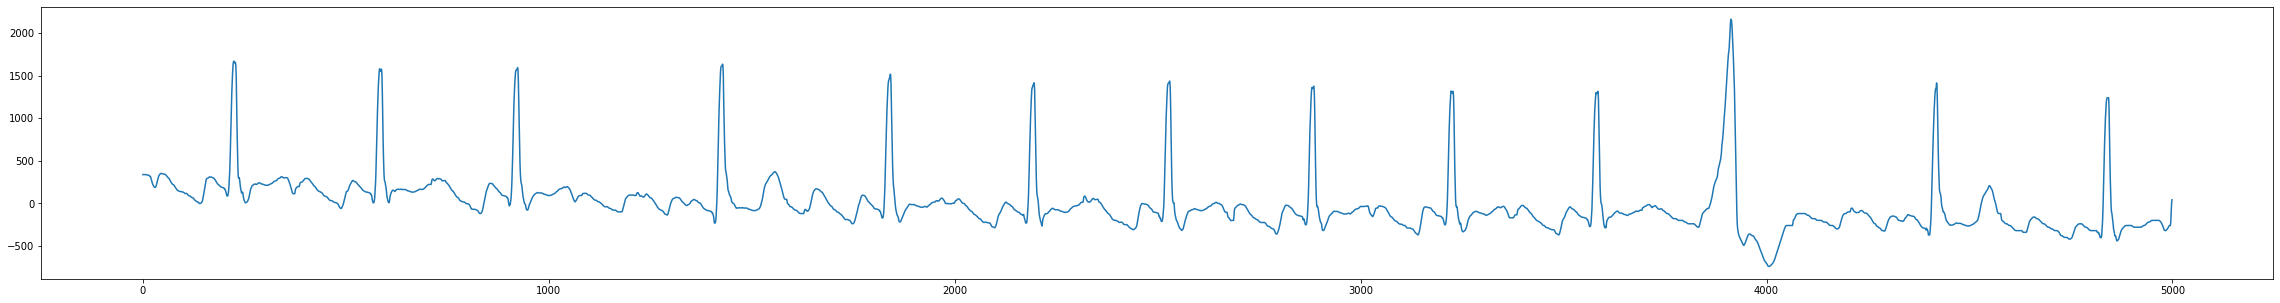

p  


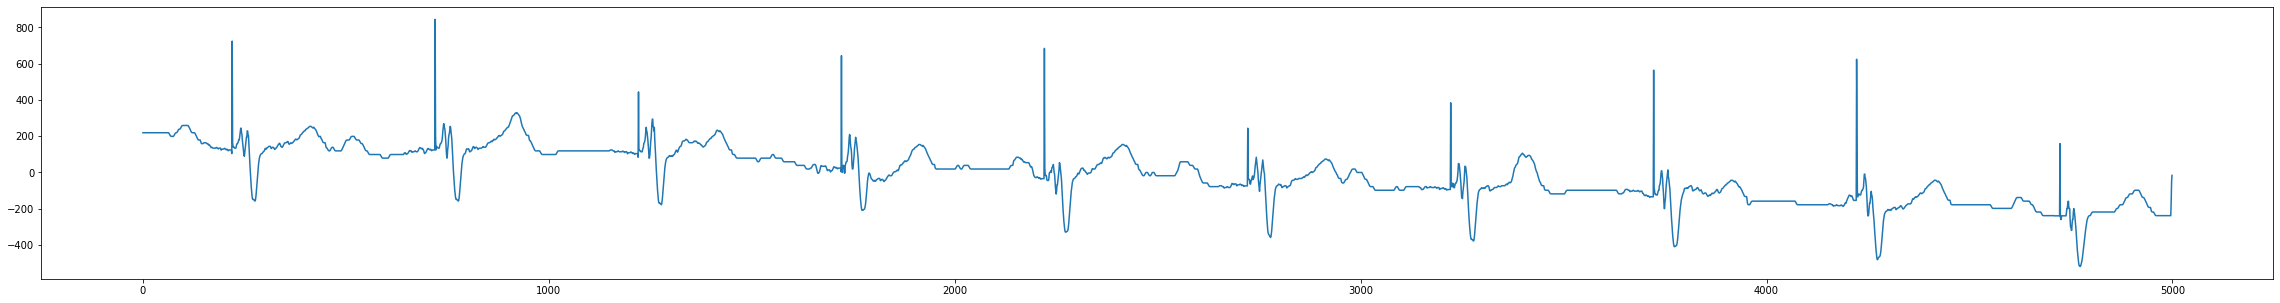

p  


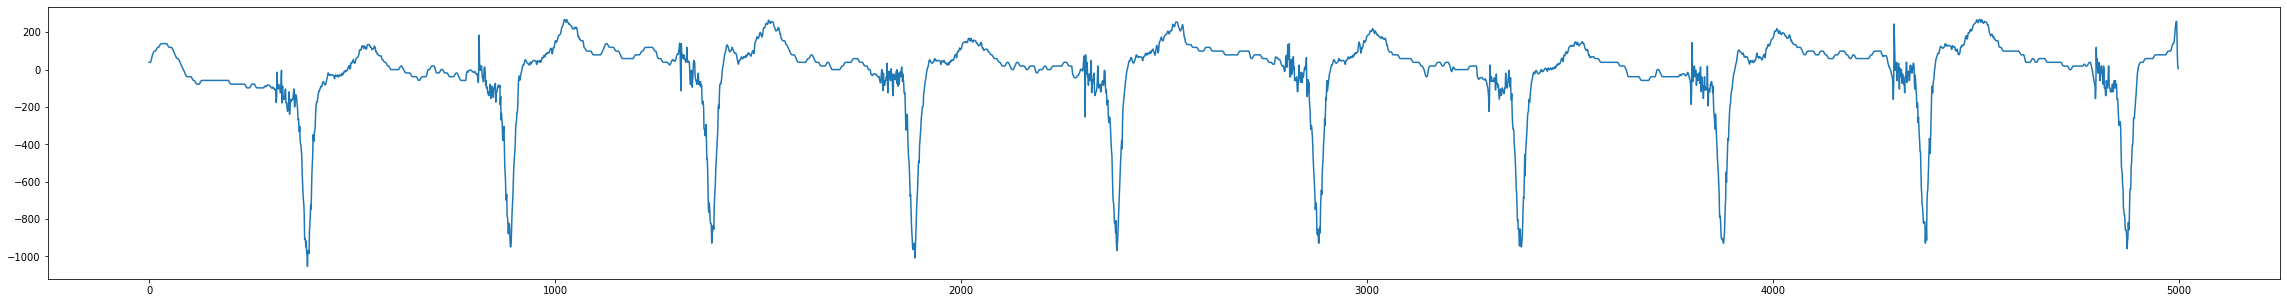

p  


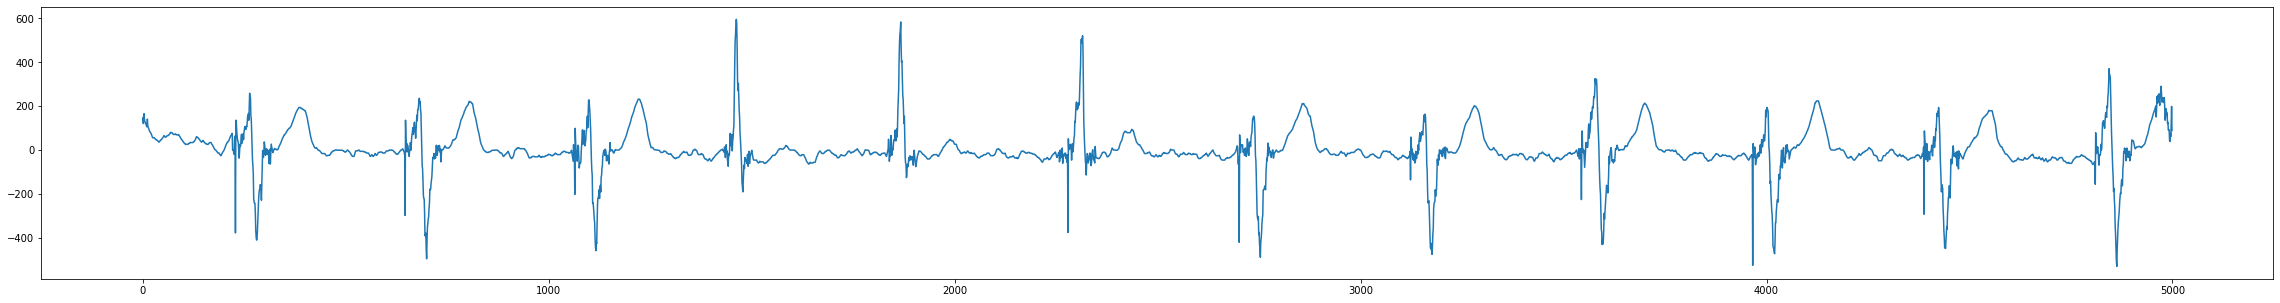

p  


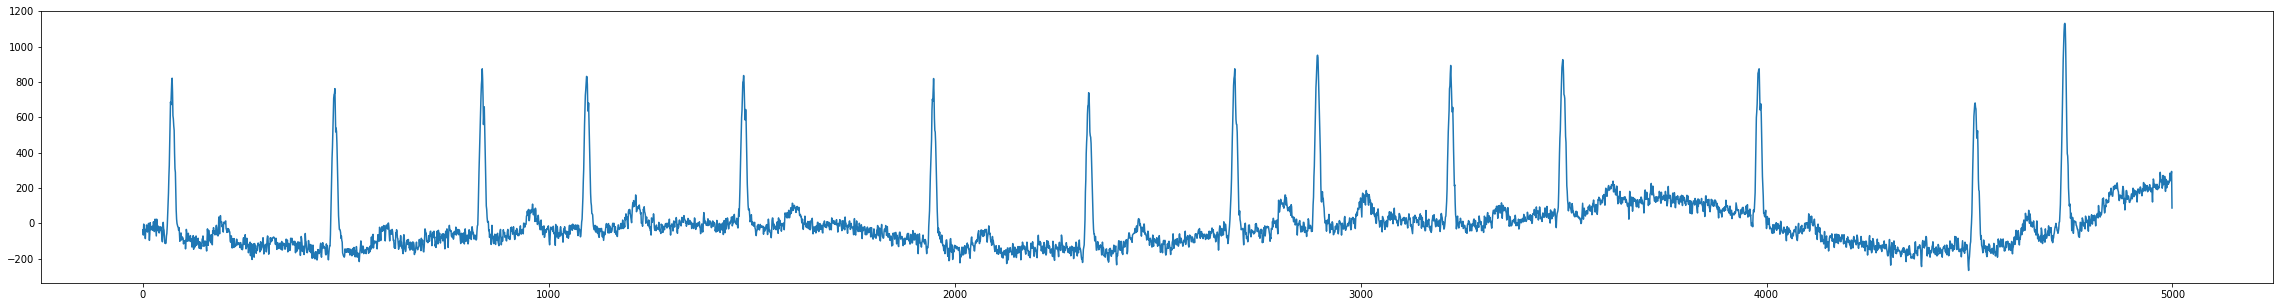

p  


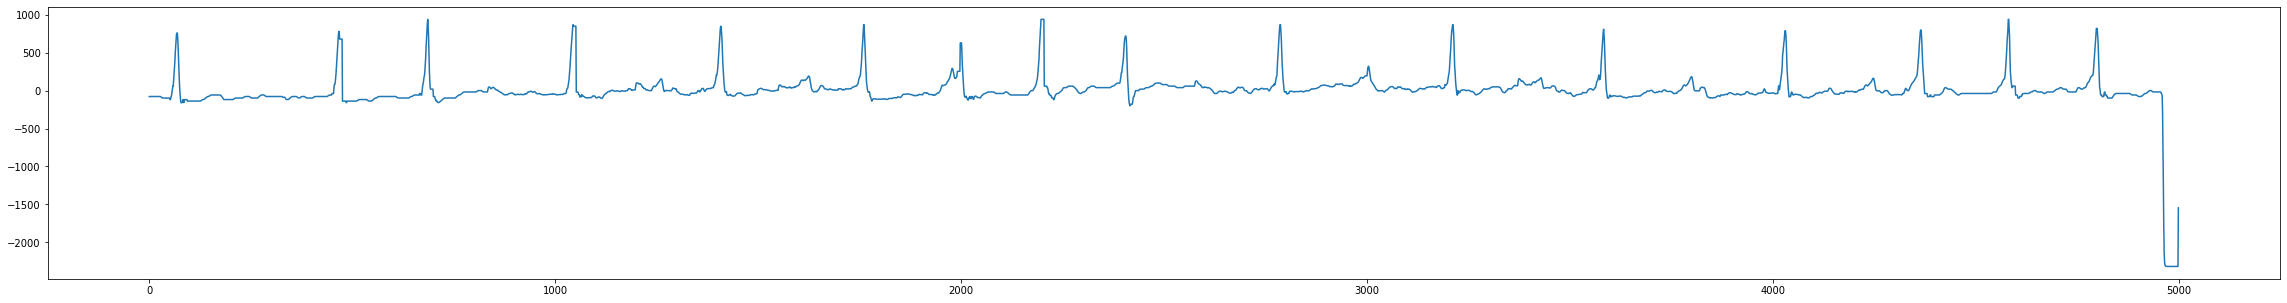

p  


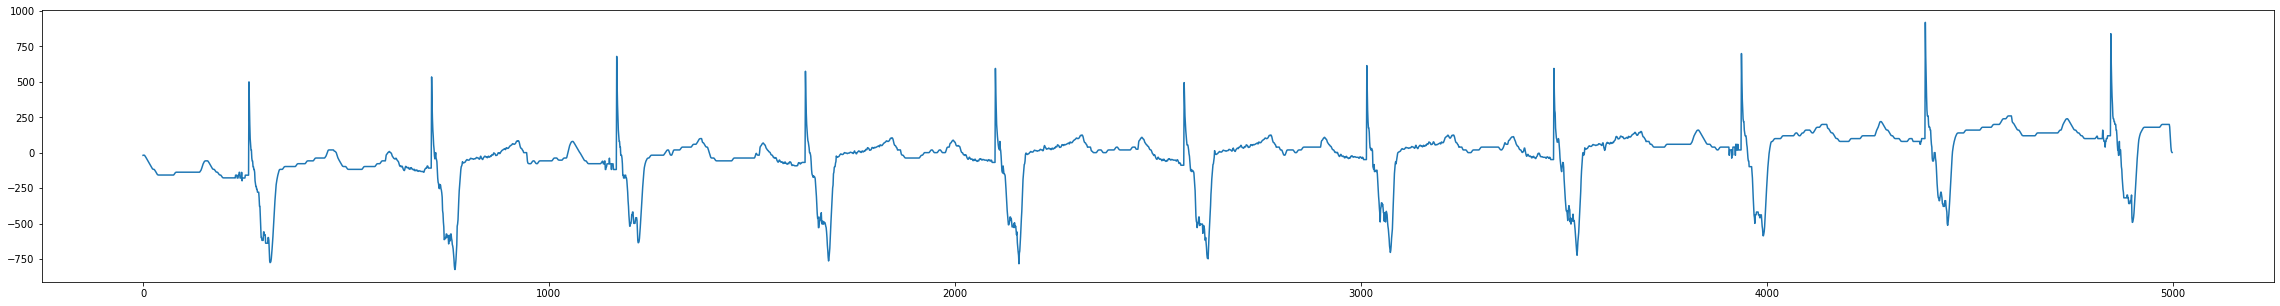

p  


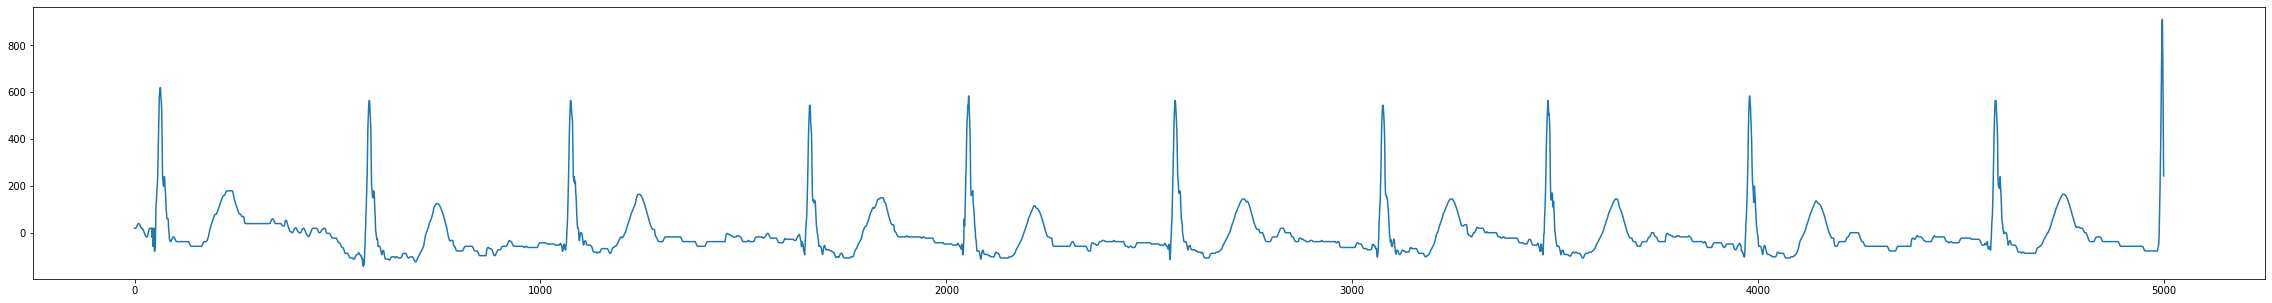

p  


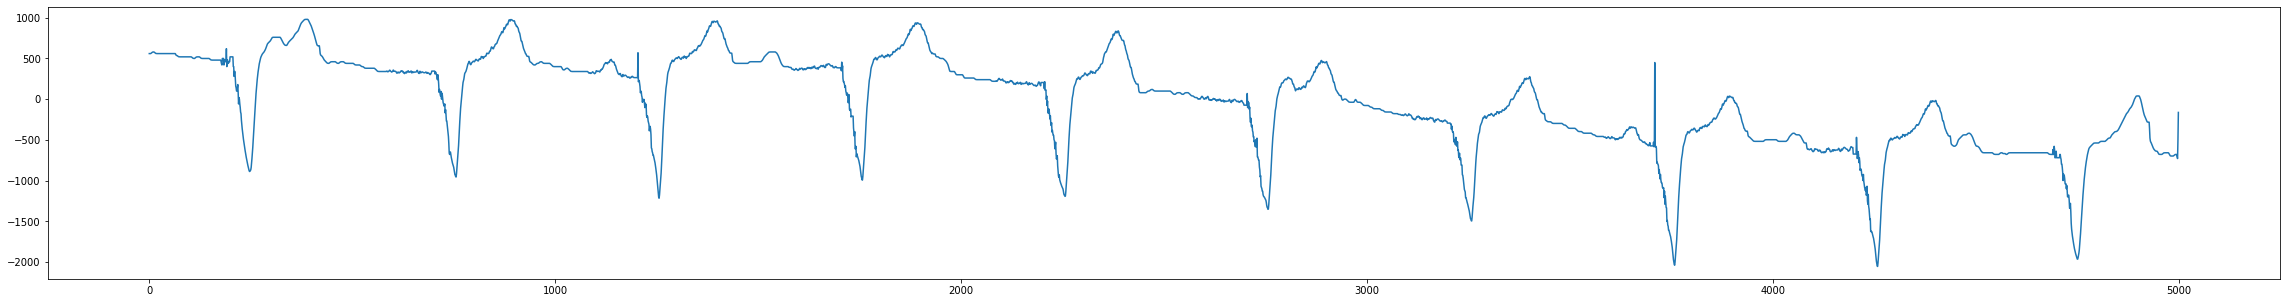

p  


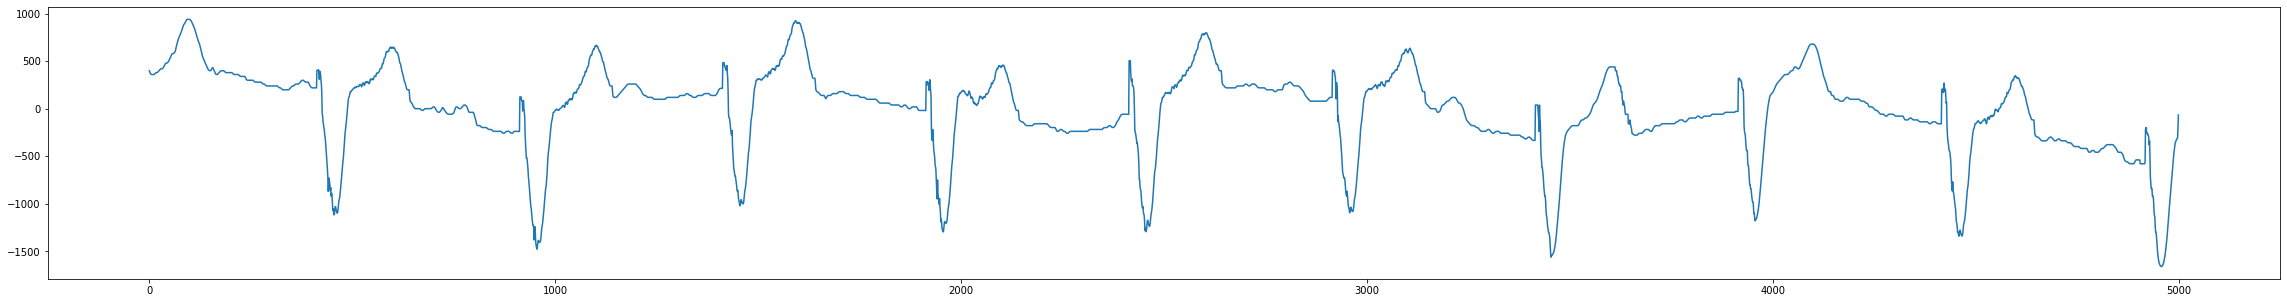

p  


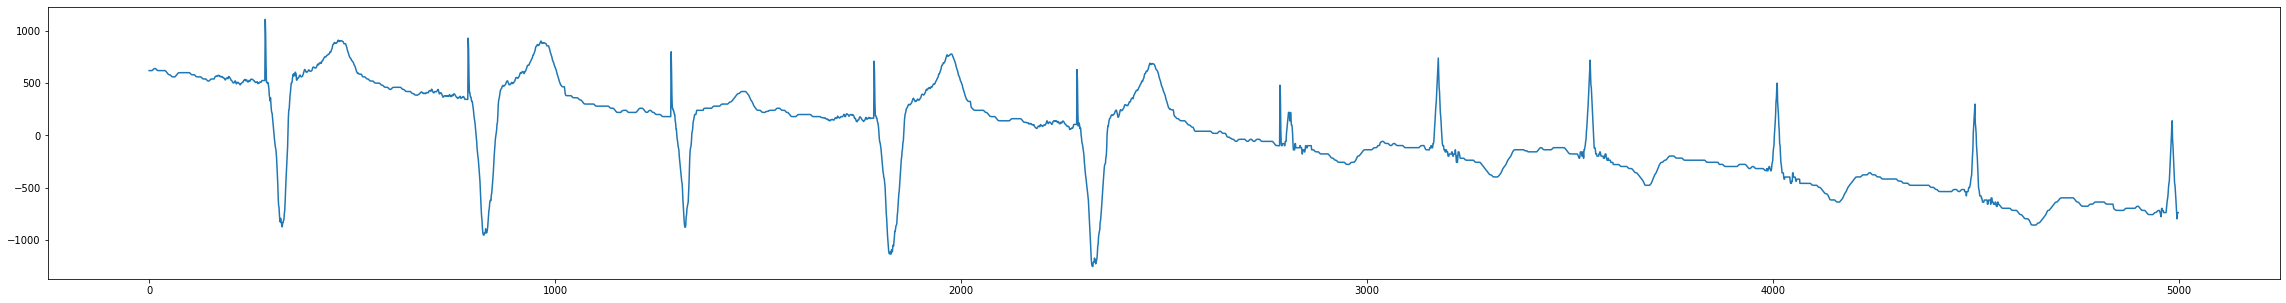

p  


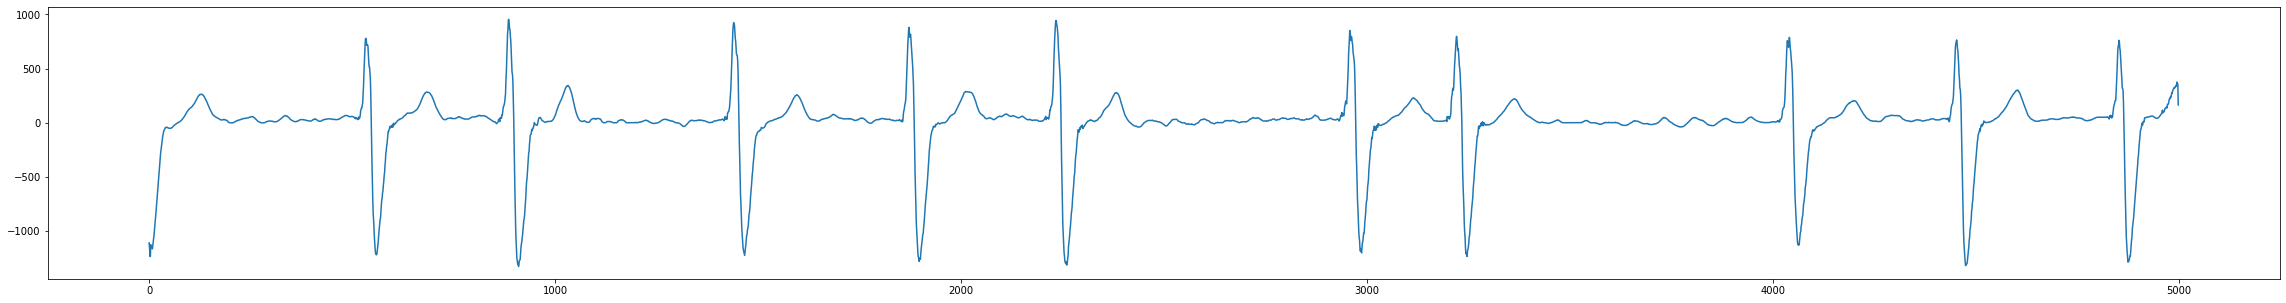

p  


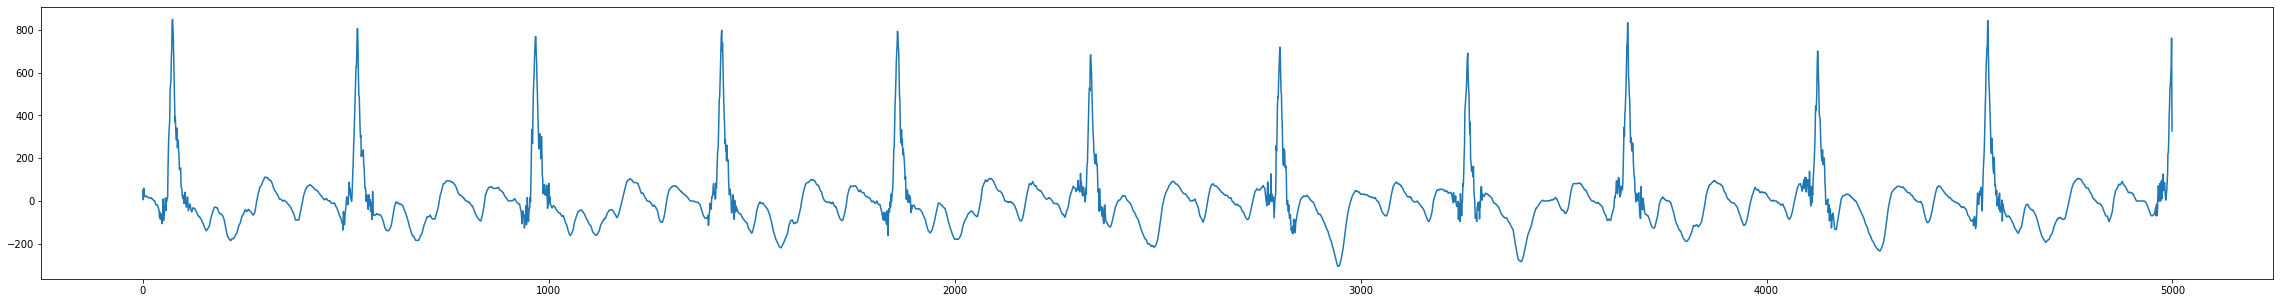

p  


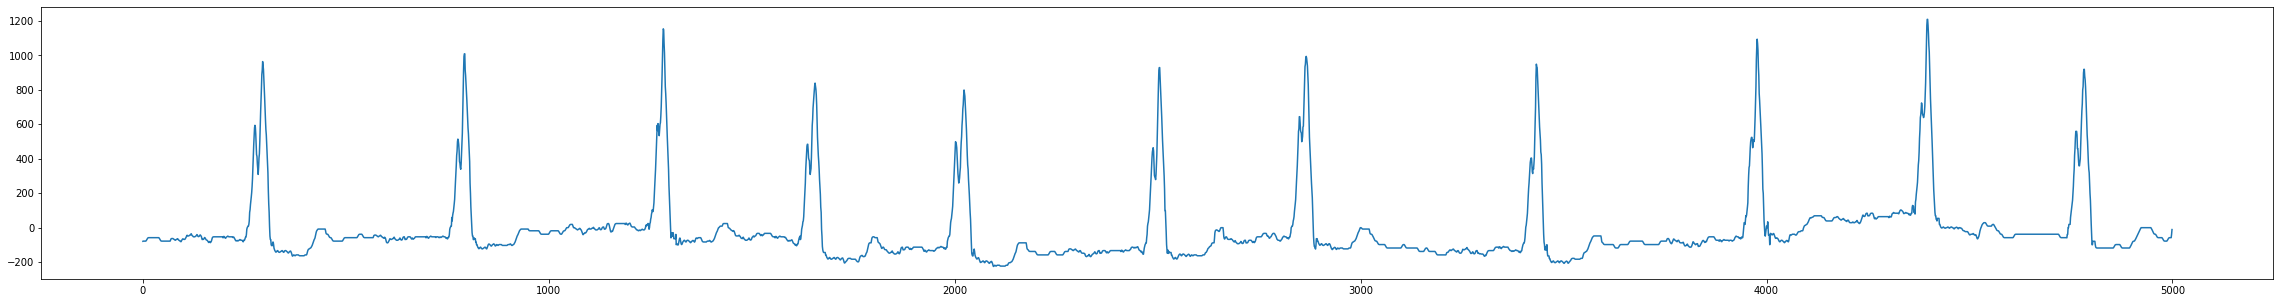

p  


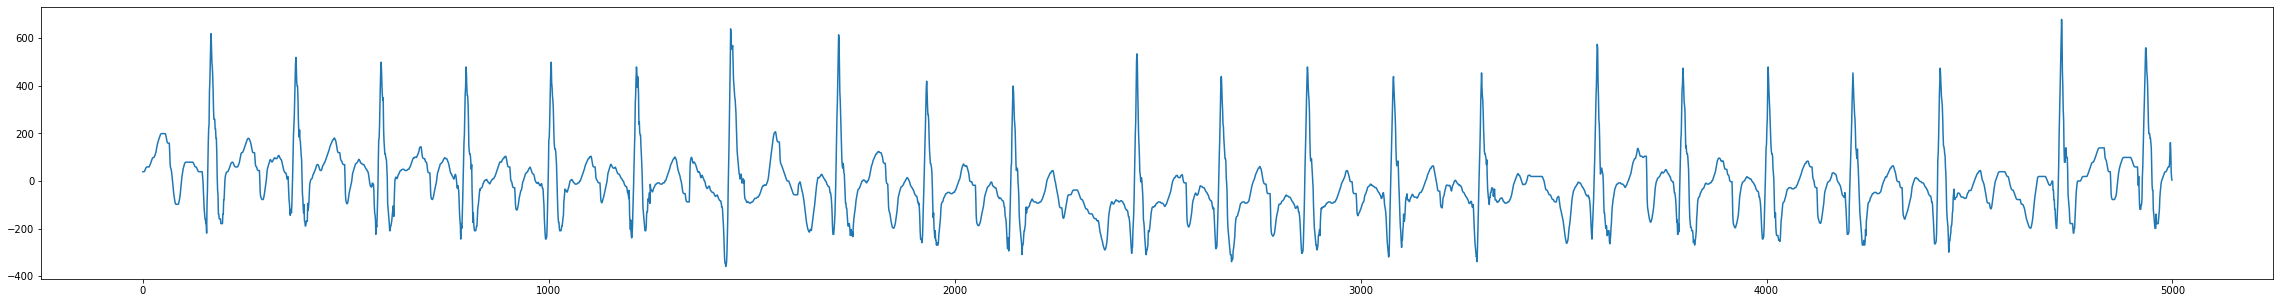

p  


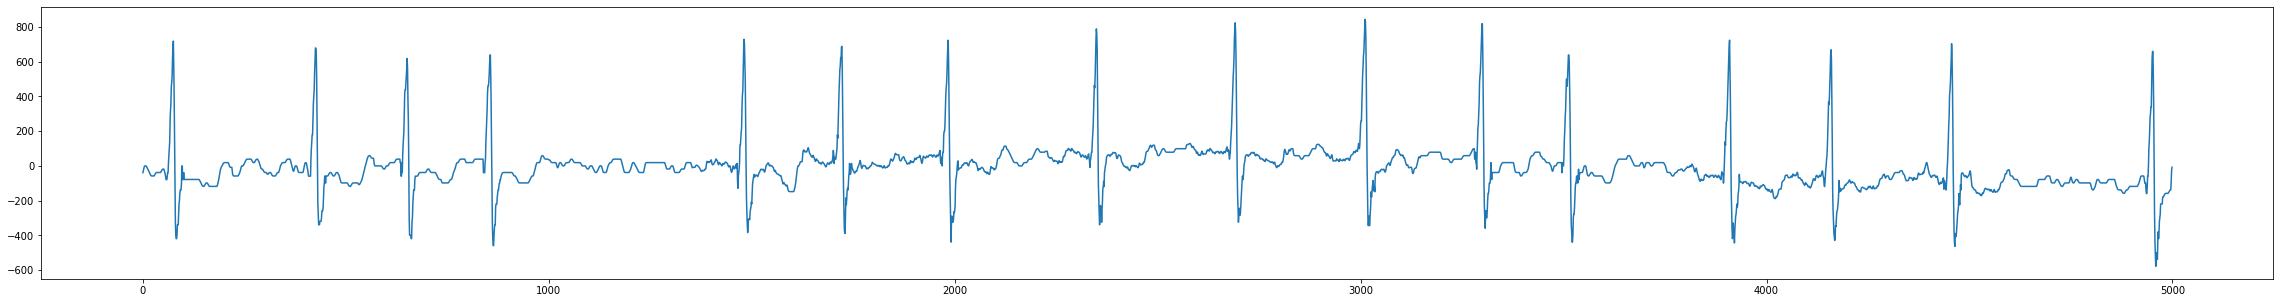

p  


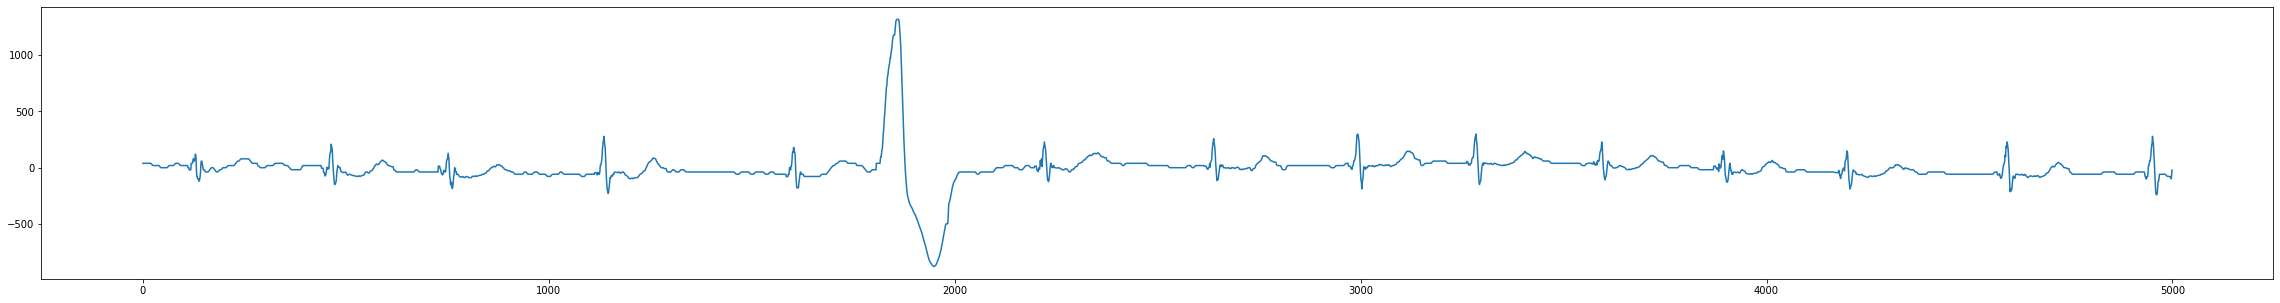

p  


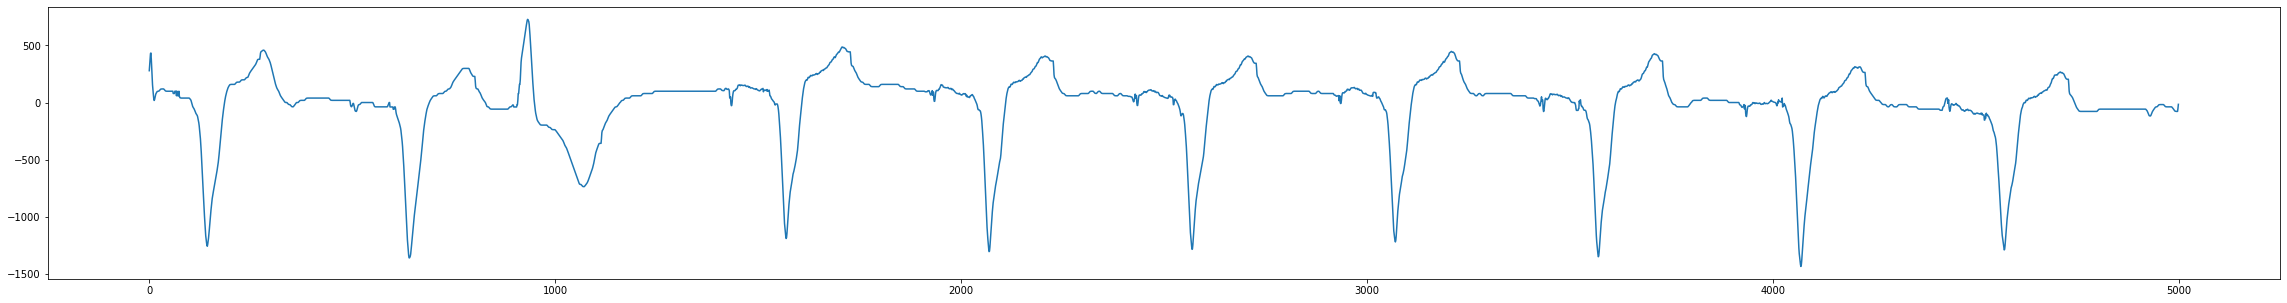

p  


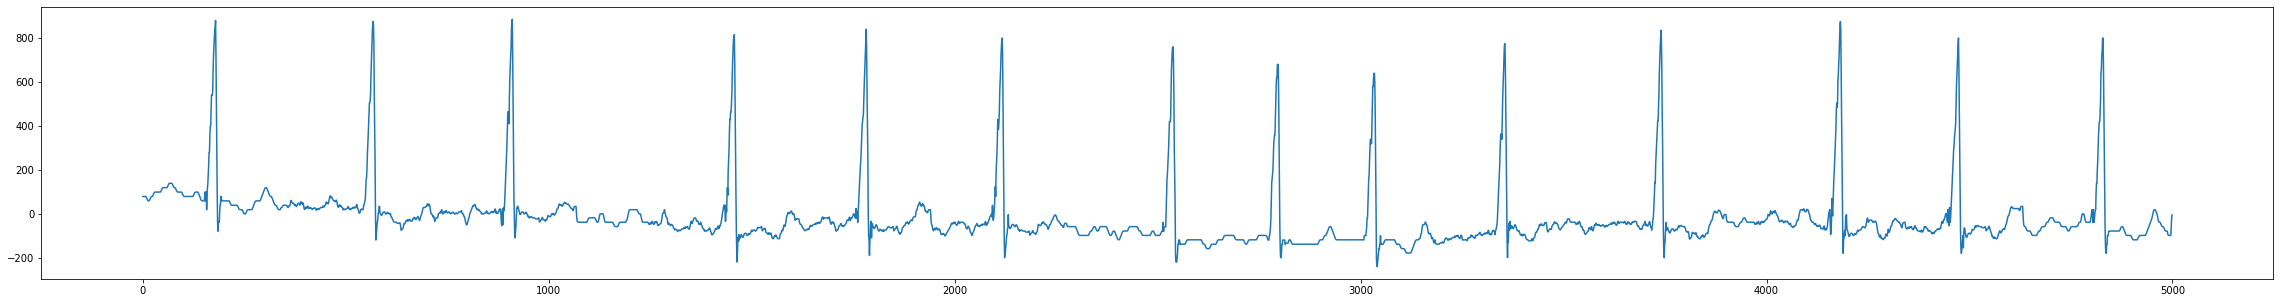

p  


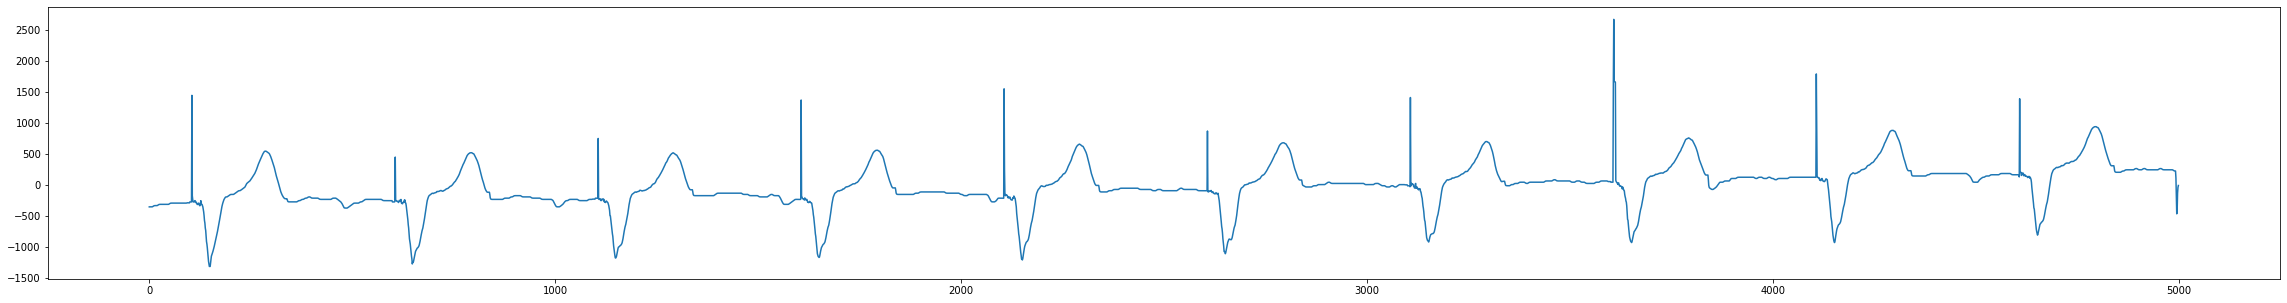

p  


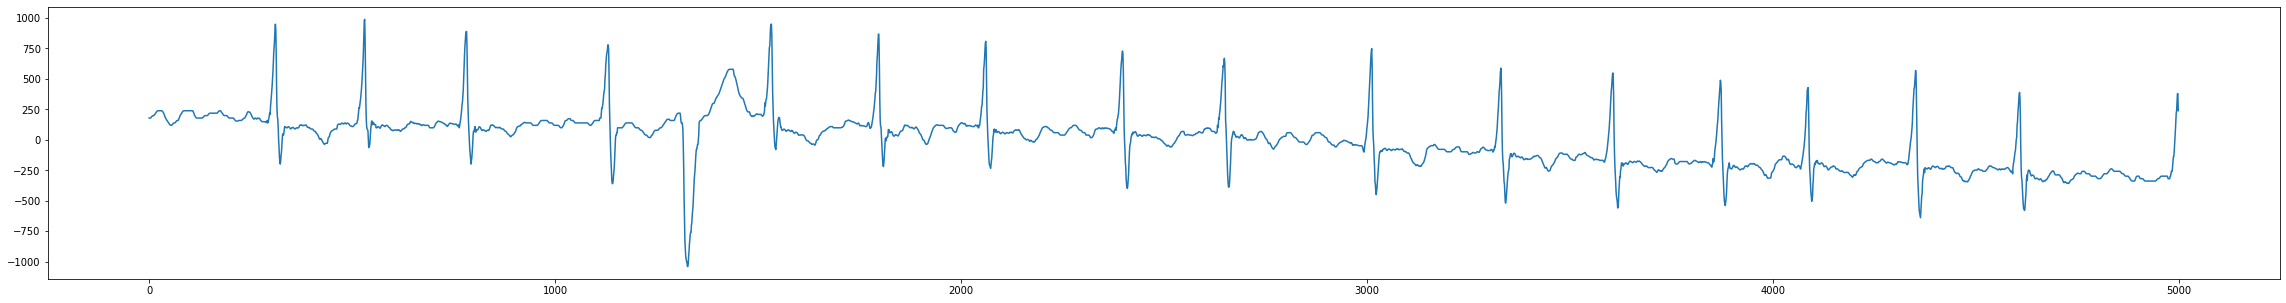

p  


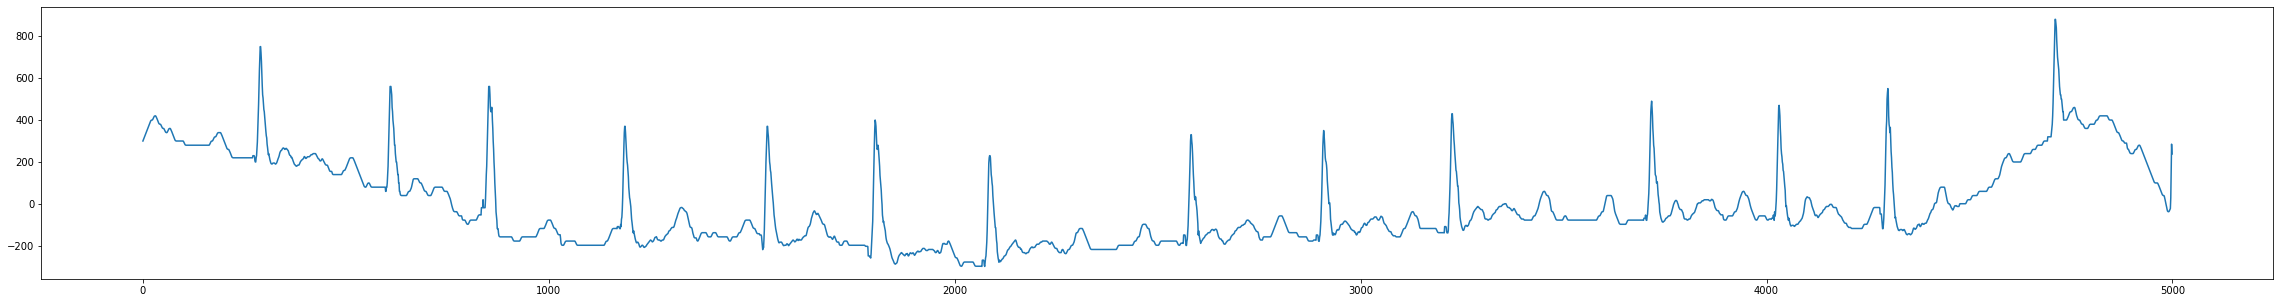

p  


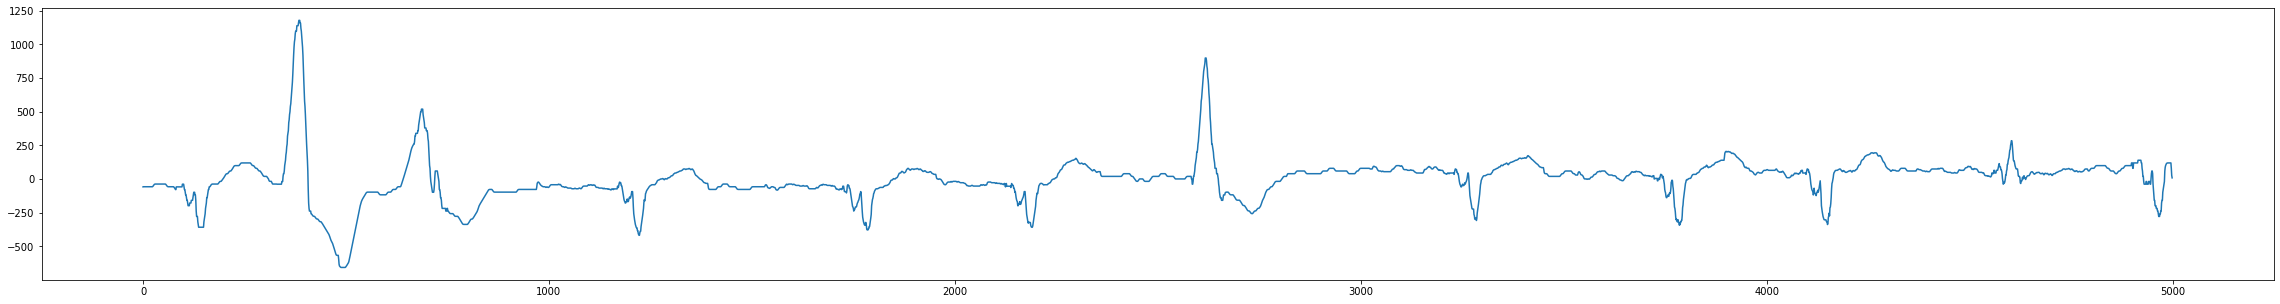

p  


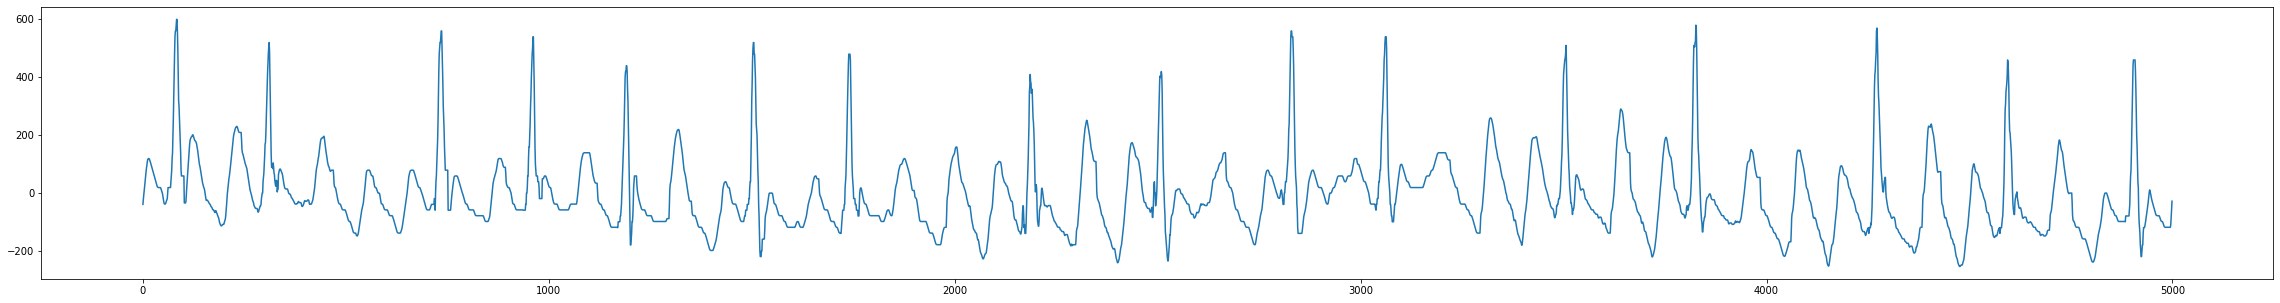

p  


In [44]:
check_ludb_label(os.environ['HOME'] + "/PQRST/unet/data/ecg_data_200.json")

In [122]:
ekg_sig = []
for i in range(1, 126):
    ekg_filename = '/home/Wr1t3R/PQRST/unet/data/IEC/IEC_from_audicor/CSE'+ str(i).rjust(3, '0') + '.raw'
    try:
        sig = read_IEC(ekg_filename)
        sig = np.reshape(sig[0], (len(sig[0]), 1))
        ekg_sig.append(sig.astype(float))
    except IOError:
        print("file {} does not exist".format("CSE"+str(i).rjust(3, '0')))
ekg_sig = np.swapaxes(ekg_sig, 1, 2)

file CSE006 does not exist
file CSE010 does not exist
file CSE018 does not exist
file CSE020 does not exist
file CSE023 does not exist
file CSE045 does not exist
file CSE050 does not exist
file CSE052 does not exist
file CSE054 does not exist
file CSE056 does not exist
file CSE057 does not exist
file CSE067 does not exist
file CSE070 does not exist
file CSE089 does not exist
file CSE092 does not exist
file CSE093 does not exist
file CSE094 does not exist
file CSE100 does not exist
file CSE109 does not exist
file CSE111 does not exist
file CSE117 does not exist
file CSE119 does not exist
file CSE120 does not exist
file CSE121 does not exist
file CSE122 does not exist


In [123]:
sig = ekg_denoise(ekg_sig[7].copy())

/home/Wr1t3R/.local/share/virtualenvs/unet-YAYnS212/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 12 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


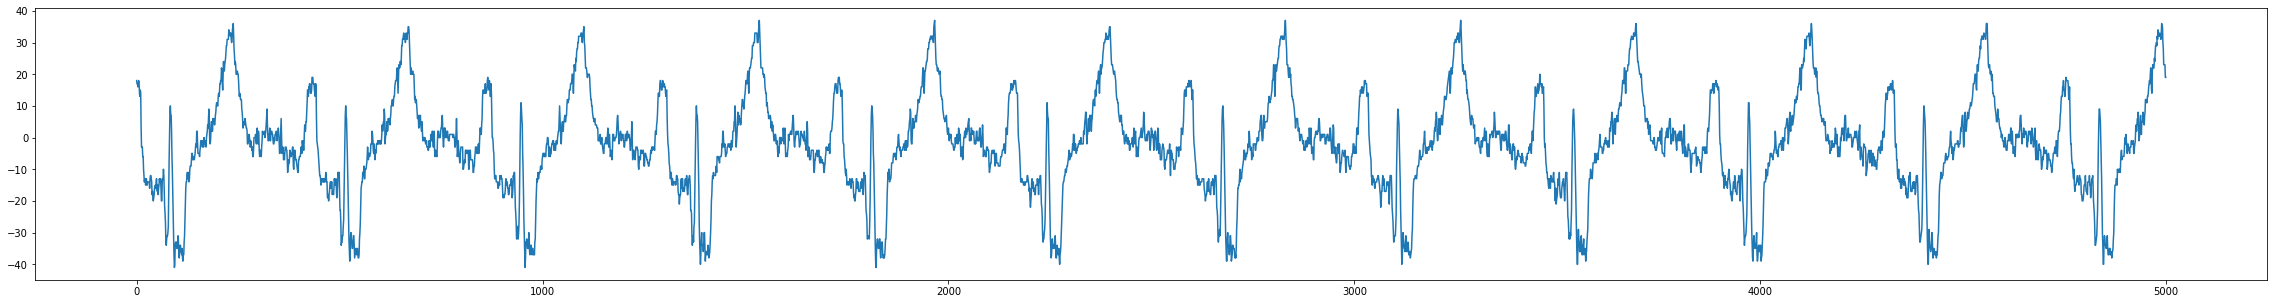

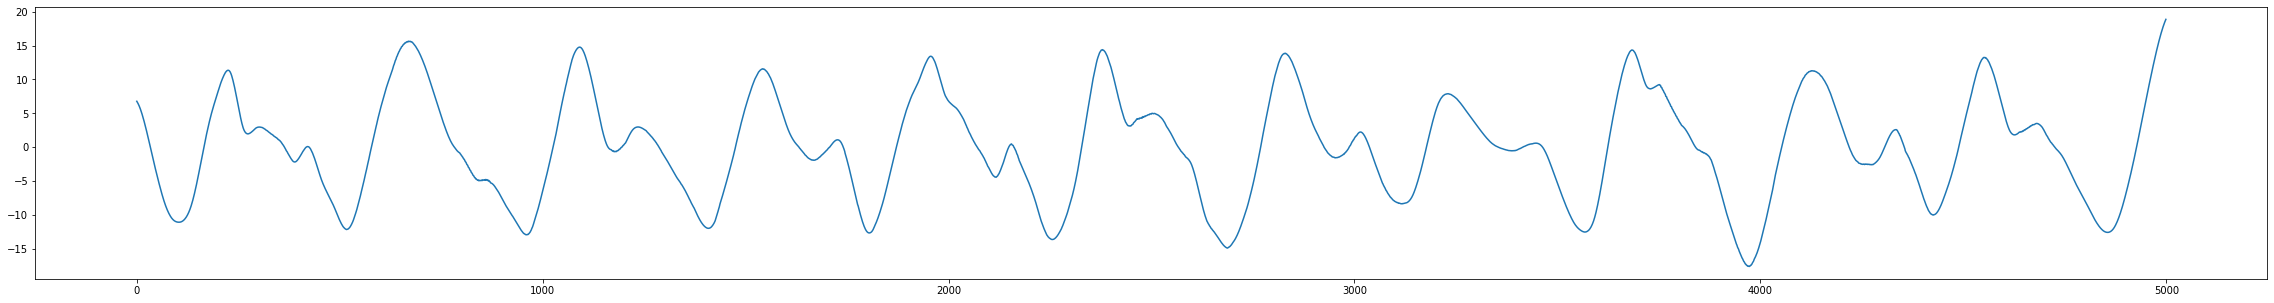

In [124]:
plot(ekg_sig[7])
plot(sig)

1151.79375
174.08


/home/Wr1t3R/.local/share/virtualenvs/unet-YAYnS212/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 12 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


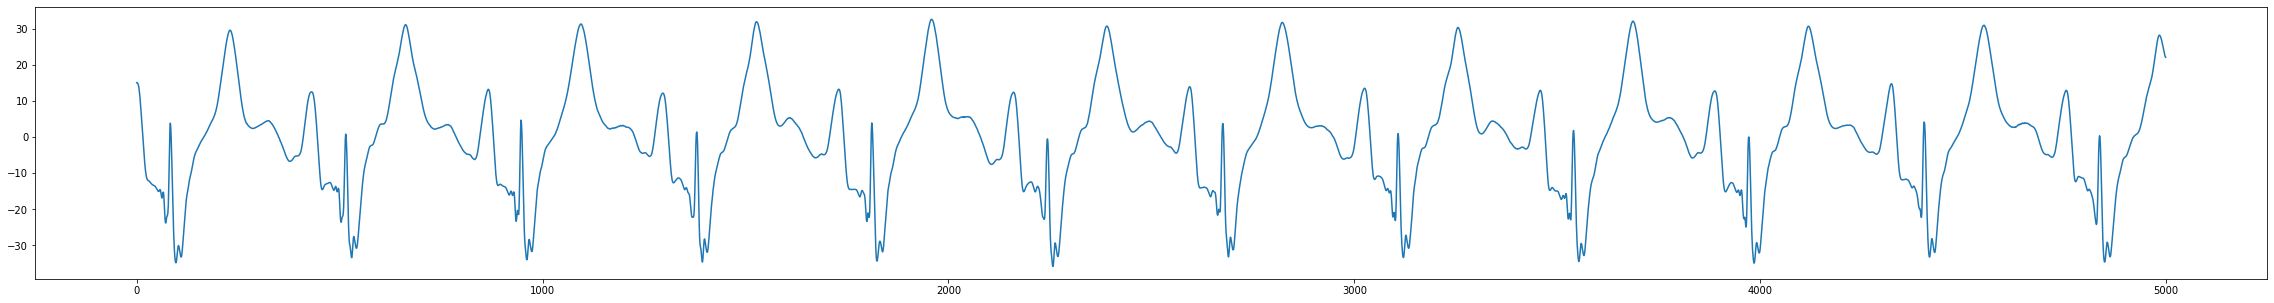

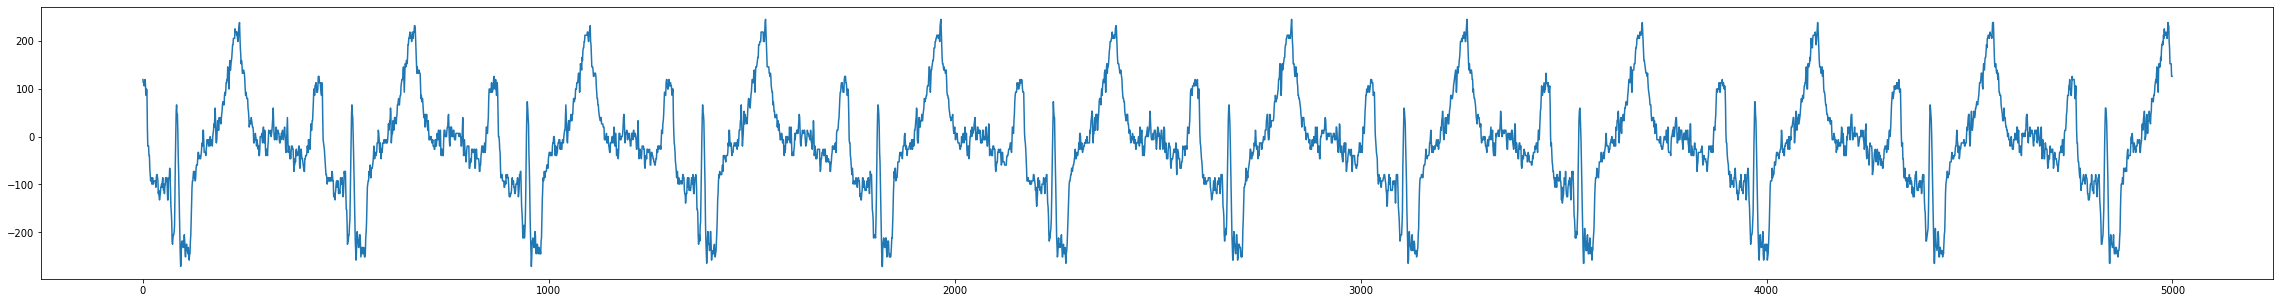

In [118]:
mean = np.mean(np.max(abs(signals), axis=2))
ekg_sig_mean = np.mean(np.max(abs(ekg_sig), axis=2))
print(mean)
print(ekg_sig_mean)
scale = mean / ekg_sig_mean
ekg_sig *= scale
sig = ekg_denoise(ekg_sig[7].copy())
sig /= scale
plot(sig)
plot(ekg_sig[7])

In [ ]:
ekg_sig = []
ekg_filename = '/home/Wr1t3R/PQRST/unet/data/IEC/IEC_from_audicor/CAL50000_4.raw'
try:
    sig = read_IEC(ekg_filename)
    sig = np.reshape(sig[0], (len(sig[0]), 1))
    ekg_sig.append(sig.astype(float))
except IOError:
    print("file {} does not exist".format("CSE"+str(i).rjust(3, '0')))
ekg_sig = np.swapaxes(ekg_sig, 1, 2)
plot(ekg_denoise(ekg_sig[0]))

In [25]:
datalist = ['大檢查audicor_normal/NOR109/PP-01_003046.bin', '大檢查audicor_normal/NOR020/PP-01_000993.bin',
           '大檢查audicor_normal/NOR031/PP-01_001057.bin', '大檢查audicor_normal/NOR059/PP-01_001852.bin',
           '大檢查audicor_normal/NOR092/PP-01_002049.bin', '大檢查audicor_abnormal/AHF041/PP-01_000305.bin',
           '大檢查audicor_abnormal/AHF065/AH090208/PP-01_000382.bin', '大檢查audicor_abnormal/AHF083/A031009a/PP-01_000467.bin',
           '大檢查audicor_abnormal/AHF120/A020110a/PP-01_000653.bin', '大檢查audicor_abnormal/AHF167/AH010411/PP-01_001073.bin']
res = np.zeros((10, 4, 10000))
for i in range(10):
    signals, sampling_rate = get_ekg("./data/big_exam/" + datalist[i])
    A,S,W = ica1(signals[8:], 2)
    res[i, 0, :] = S[0]
    res[i, 1, :] = S[1]
    res[i, 2, :] = signals[8]
    res[i, 3, :] = signals[9]
np.save("test.npy", res)

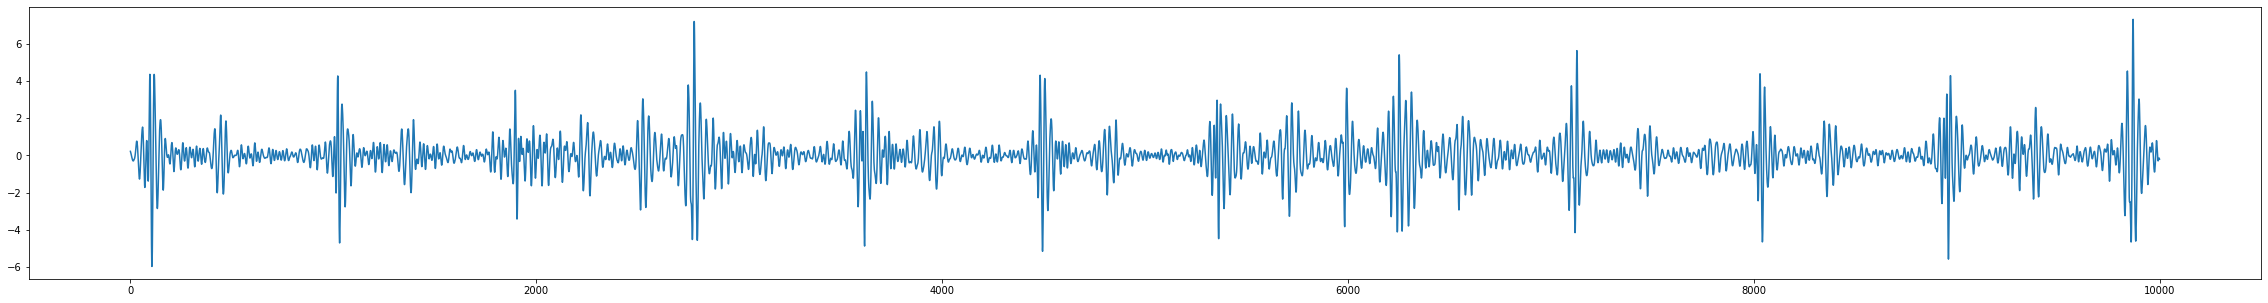

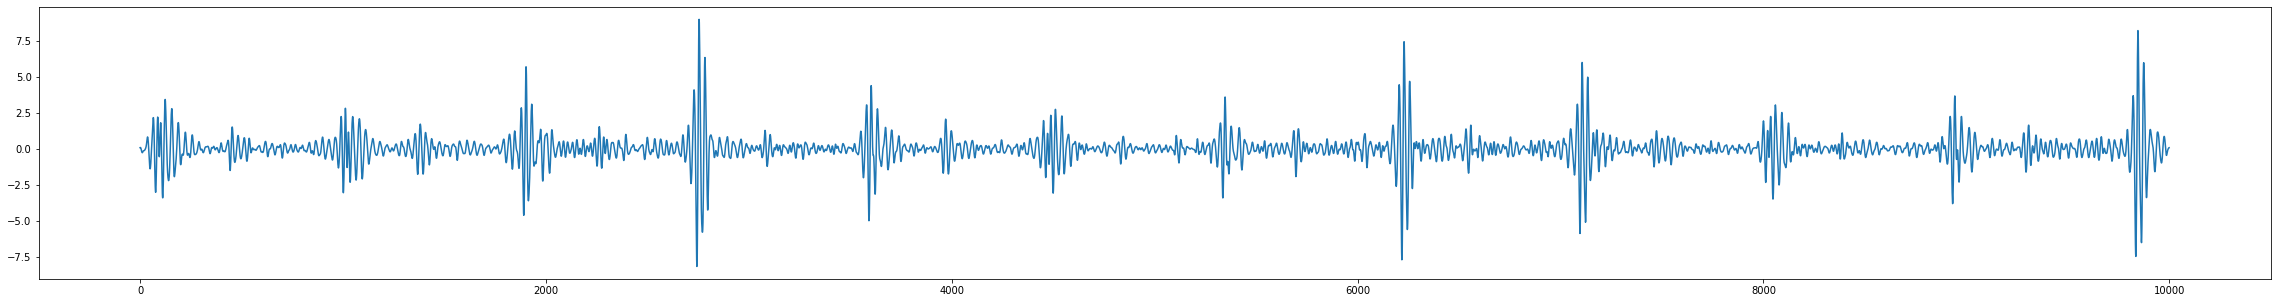

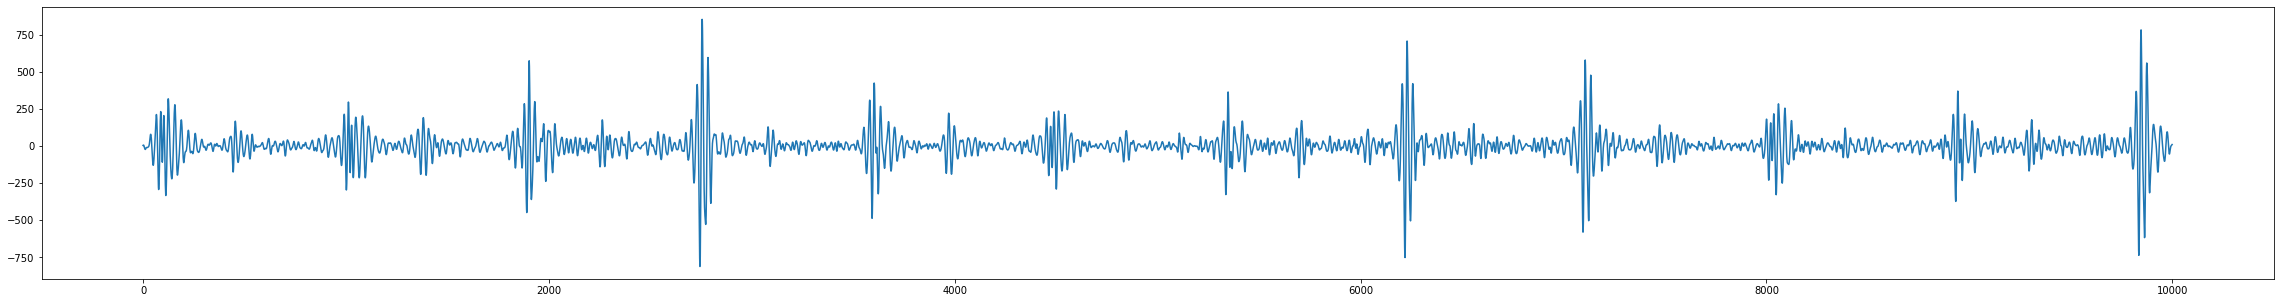

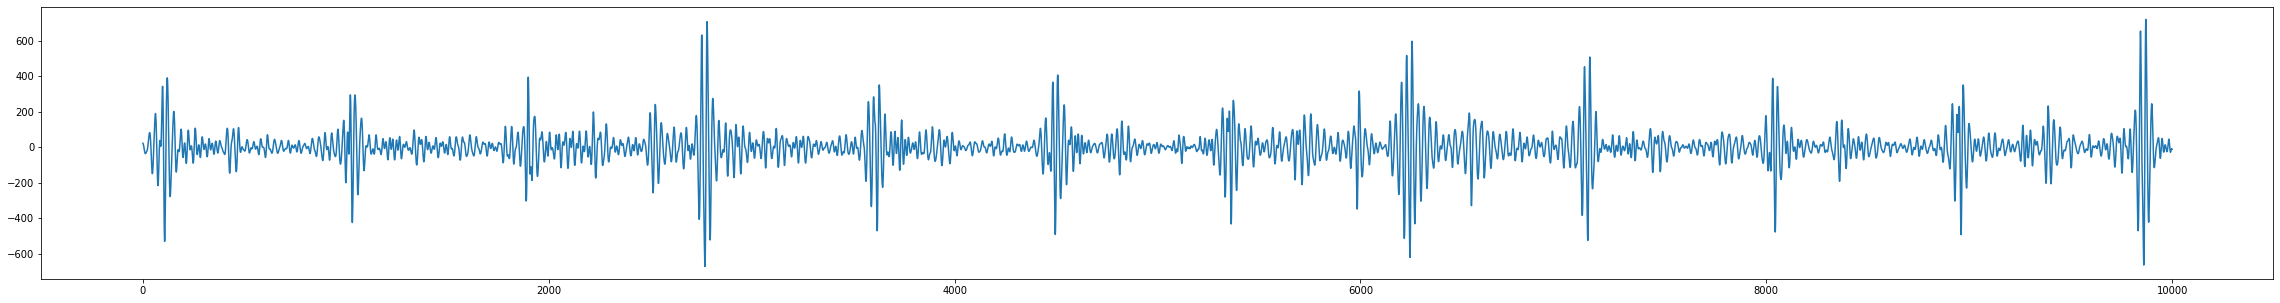

In [28]:
ss = np.load("test.npy")
s1 = ss[0, 0, :].reshape((1, -1))
s2 = ss[0, 1, :].reshape((1, -1))
s3 = ss[0, 2, :].reshape((1, -1))
s4 = ss[0, 3, :].reshape((1, -1))
plot(s1)
plot(s2)
plot(s3)
plot(s4)